In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, BatchNormalization, Conv2DTranspose, Flatten, Dropout, Activation, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# 10% validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state=42, stratify=y_train)
print("Post validation shapes:")
print("Train:", x_train.shape, "\nVal:", x_val.shape, "\nTest:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Post validation shapes:
Train: (45000, 32, 32, 3) 
Val: (5000, 32, 32, 3) 
Test: (10000, 32, 32, 3)


In [3]:
def display_images(original, reconstructed, n=10):
    idx = np.random.choice(len(original), size=n, replace=False)

    plt.figure(figsize=(2*n, 4))
    for i, k in enumerate(idx):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[k])
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

        # Reconstruction
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[k])
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstruction")

    plt.show()

# **Autoencoder #1**


*   6 Encoder Layers
*   7 Decoder Layers (6 + 1 for output)
*   Decreasing channels in encoder: 32 -> 16 -> 8
*   **Latent Space Image Dimensions: 4x4x8 = 128**
*   Learning rate -> 0.0001

In [ ]:
input_img = Input(shape=(32,32,3))

encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)    # 32x32x32
encoded = MaxPooling2D((2, 2)) (encoded)    # 16x16x32

encoded = Conv2D(16, (3, 3), activation='relu', padding='same') (encoded)   # 16x16x16
encoded = MaxPooling2D((2, 2)) (encoded)    # 8x8x16

encoded = Conv2D(8, (3, 3), activation='relu', padding='same') (encoded)    # 8x8x8
latent = MaxPooling2D((2, 2)) (encoded)     # 4x4x8

decoded = Conv2D(8, (3, 3), activation='relu', padding='same') (latent)   # 4x4x8
decoded = UpSampling2D((2, 2)) (decoded)    # 8x8x8

decoded = Conv2D(16, (3, 3), activation='relu', padding='same') (decoded)   # 8x8x16
decoded = UpSampling2D((2, 2)) (decoded)    # 16x16x16

decoded = Conv2D(32, (3, 3), activation='relu', padding='same') (decoded)   # 16x16x32
decoded = UpSampling2D((2, 2)) (decoded)    # 32x32x32

decoded_img = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(decoded)    # 32x32x3

In [ ]:
AE1 = Model(input_img, decoded_img)
AE1.compile(optimizer = Adam(learning_rate=0.0001), loss ='mse')
AE1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,939 (54.45 KB)

 Trainable params: 13,939 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)]

metrics = AE1.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0121 - mae: 0.0799 - val_loss: 0.0121 - val_mae: 0.0800
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0120 - mae: 0.0798 - val_loss: 0.0120 - val_mae: 0.0797
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0120 - mae: 0.0798 - val_loss: 0.0120 - val_mae: 0.0796
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0120 - mae: 0.0795 - val_loss: 0.0120 - val_mae: 0.0795
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0119 - mae: 0.0795 - val_loss: 0.0119 - val_mae: 0.0793
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0119 - mae: 0.0794 - val_loss: 0.0119 - val_mae: 0.0793
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0119 - mae: 0.0791 - val_loss: 0.0119 - val_mae: 0.0792
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0119 - mae: 0.0791 - val_loss: 0.0118 - val_mae: 0.0790
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


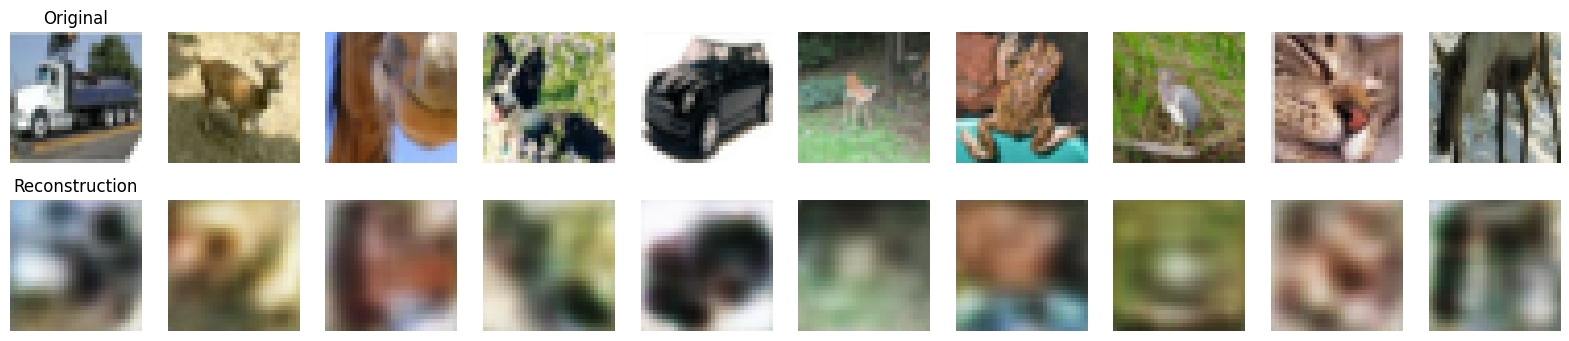

In [ ]:
decoded_val = AE1.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Autoencoder #2**


*   6 Encoder Layers
*   7 Decoder Layers
*   Increasing channels in encoder: 32 -> 64 -> 128
*   **Latent Space Image Dimensions: 4x4x128 = 2.048**
*   Learning rate -> 0.0001

In [ ]:
input_img = Input(shape=(32,32,3))    # 32x32x3

# Encoder
encoded = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)   # 32x32x32
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 16x16x32

encoded = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)   # 16x16x64
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 8x8x64

encoded = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)    # 8x8x128
latent = MaxPooling2D((2,2), padding='same', name="latent")(encoded)   # 4x4x128

# Decoder
decoded = UpSampling2D((2,2))(latent)   # 8x8x128
decoded = Conv2D(128, (3,3), activation='relu', padding='same')(decoded)    # 8x8x128

decoded = UpSampling2D((2,2))(decoded)    # 16x16x128
decoded = Conv2D(64, (3,3), activation='relu', padding='same')(decoded)   # 16x16x64

decoded = UpSampling2D((2,2))(decoded)    # 32x32x64
decoded = Conv2D(32, (3,3), activation='relu', padding='same')(decoded)   # 32x32x32

decoded_img = Conv2D(3, (3,3), activation='sigmoid', padding='same')(decoded)   # 32x32x3 οπως η αρχικη!
AE2 = Model(input_img, decoded_img)
AE2.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)]

start = time.time()
metrics2 = AE2.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


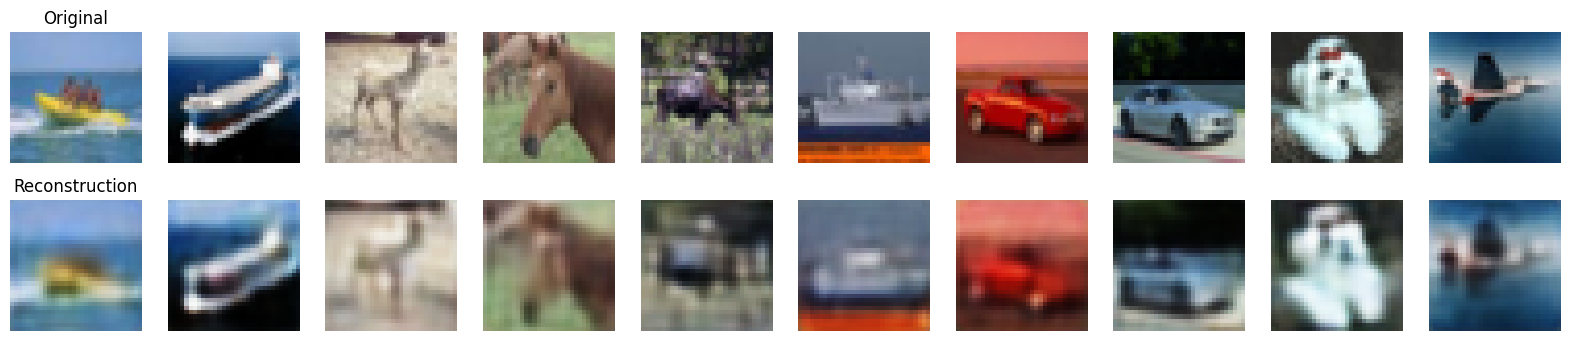

In [ ]:
decoded_val = AE2.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Autoencoder #3**

Same as Autoencoder #2, but adding learning rate scheduler and changing starting learning rate from 0.0001 -> 0.0005

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

AE3 = AE2
AE3.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

In [ ]:
start = time.time()
metrics3 = AE3.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0048 - val_loss: 0.0046 - learning_rate: 5.0000e-04
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0047 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0047 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0045 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 5/50
349/352 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 5.0000e-04
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


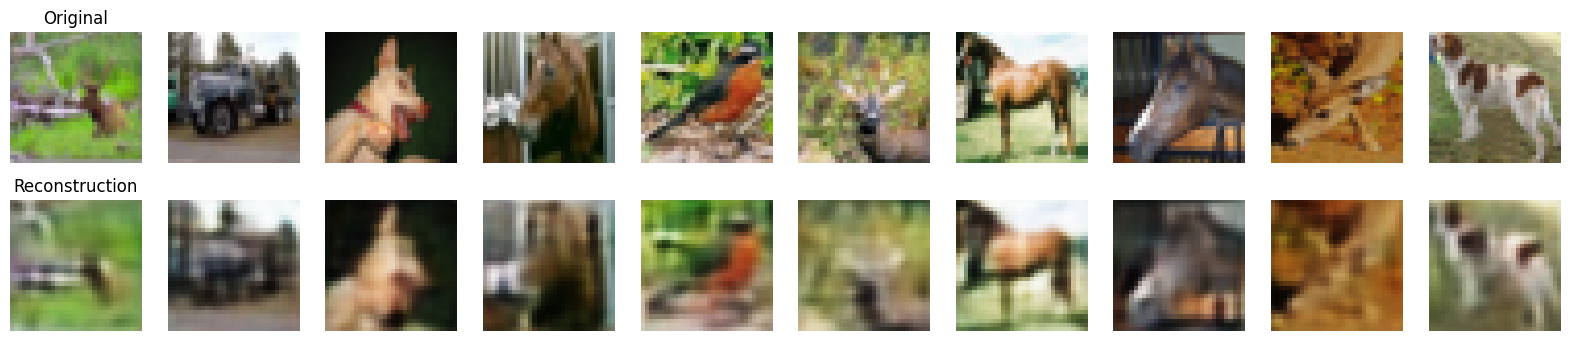

In [ ]:
decoded_val = AE3.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Autoencoder #4**

*   6 Encoder Layers
*   4 Decoder Layers (Conv2DTranspose)
*   Increasing channels in encoder: 32 -> 64 -> 128
*   **Latent Space Image Dimensions: 4x4x128 = 2.048**
*   Learning rate -> 0.001


In [ ]:
input_img = Input(shape=(32,32,3))    # 32x32x3

# Encoder
encoded = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)   # 32x32x32
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 16x16x32

encoded = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)   # 16x16x64
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 8x8x64

encoded = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)    # 8x8x128
latent = MaxPooling2D((2,2), padding='same', name="latent")(encoded)   # 4x4x128

# Decoder

decoded = Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same')(latent)    # 8x8x128
decoded = Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(decoded)   # 16x16x64
decoded = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(decoded)   # 32x32x32
decoded_img = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(decoded)   # 32x32x3

AE4 = Model(input_img, decoded_img)
AE4.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics =["mae"])

In [ ]:
AE4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

start = time.time()
metrics4 = AE4.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0309 - mae: 0.1342 - val_loss: 0.0103 - val_mae: 0.0750 - learning_rate: 0.0010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0095 - mae: 0.0718 - val_loss: 0.0079 - val_mae: 0.0655 - learning_rate: 0.0010
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0077 - mae: 0.0642 - val_loss: 0.0066 - val_mae: 0.0587 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0065 - mae: 0.0582 - val_loss: 0.0060 - val_mae: 0.0554 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0059 - mae: 0.0554 - val_loss: 0.0057 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0056 - mae: 0.0537 - val_loss: 0.0054 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0053 - mae: 0.0522 - val_loss: 0.0051 - val_mae: 0.0507 - learning_rate: 0.001

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


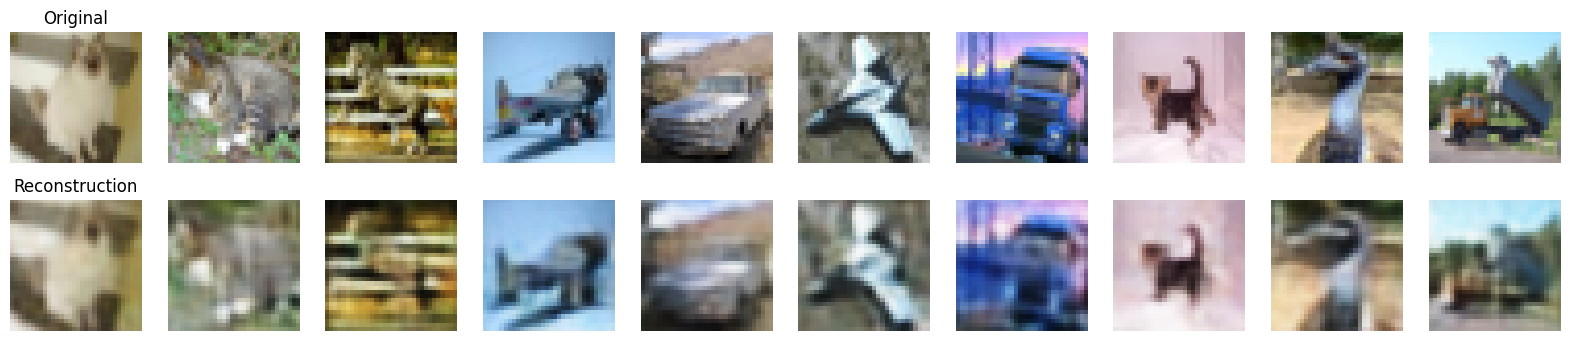

In [ ]:
decoded_val = AE4.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Autoencoder #5**

Same with Autoencoder #4 but with binary_crossentropy loss instead of MSE.

In [ ]:
input_img = Input(shape=(32,32,3))    # 32x32x3

# Encoder
encoded = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)   # 32x32x32
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 16x16x32

encoded = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)   # 16x16x64
encoded = MaxPooling2D((2,2), padding='same')(encoded)     # 8x8x64

encoded = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)    # 8x8x128
latent = MaxPooling2D((2,2), padding='same', name="latent")(encoded)   # 4x4x128

# Decoder

decoded = Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same')(latent)    # 8x8x128
decoded = Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(decoded)   # 16x16x64
decoded = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(decoded)   # 32x32x32
decoded_img = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(decoded)   # 32x32x3

AE5 = Model(input_img, decoded_img)
AE5.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics =["mse"])

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

start = time.time()
metrics5 = AE5.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.6207 - mse: 0.0305 - val_loss: 0.5729 - val_mse: 0.0103 - learning_rate: 0.0010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5727 - mse: 0.0099 - val_loss: 0.5713 - val_mse: 0.0098 - learning_rate: 0.0010
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5687 - mse: 0.0081 - val_loss: 0.5642 - val_mse: 0.0069 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5644 - mse: 0.0068 - val_loss: 0.5634 - val_mse: 0.0065 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5633 - mse: 0.0064 - val_loss: 0.5626 - val_mse: 0.0063 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5618 - mse: 0.0059 - val_loss: 0.5609 - val_mse: 0.0057 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5611 - mse: 0.0056 - val_loss: 0.5603 - val_mse: 0.0055 - learning_rate: 0.001

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


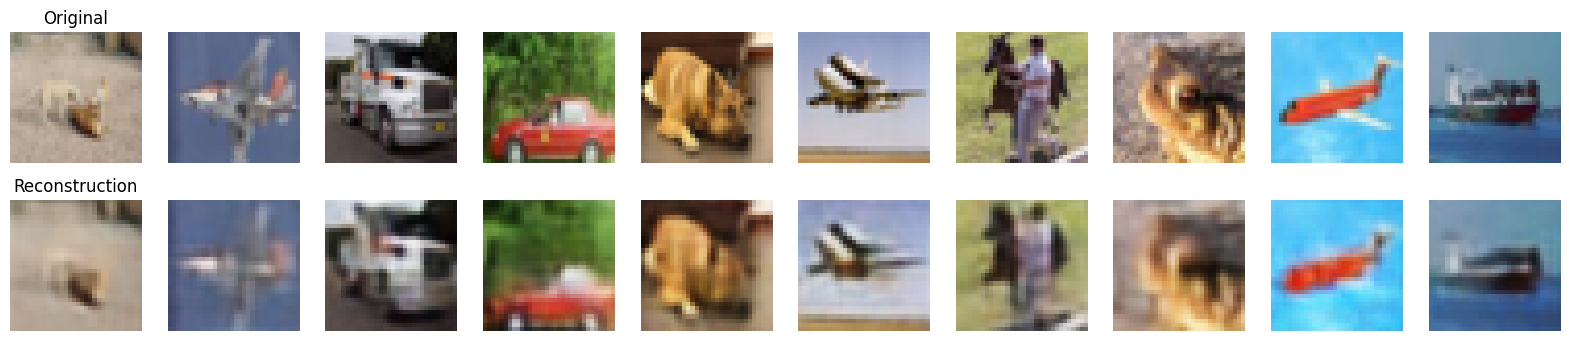

In [ ]:
decoded_val = AE5.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Autoencoder #6:**
Dense Autoencoder:
*   1 Dense Encoder Layer with 512 neurons
*   1 Decoder Layer with 32*32*3=3072 neurons
*   **Latent Space Image Dimensions: 512**

In [ ]:
input_img = Input(shape=(32,32,3))
x = Flatten()(input_img)

# Encoder
latent = Dense(512, activation='relu')(x)

# Decoder
x = Dense(32*32*3, activation='sigmoid')(latent)
output = Reshape((32,32,3))(x)

AE_dense = Model(input_img, output)
AE_dense.compile(optimizer=Adam(1e-4), loss='mse', metrics = ["mae"])

In [ ]:
AE_dense.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3072)           │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,149,312 (12.01 MB)

 Trainable params: 3,149,312 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)]

start = time.time()
metrics6 = AE_dense.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=128, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0503 - mae: 0.1828 - val_loss: 0.0293 - val_mae: 0.1360 - learning_rate: 1.0000e-04
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - mae: 0.1302 - val_loss: 0.0229 - val_mae: 0.1190 - learning_rate: 1.0000e-04
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0216 - mae: 0.1152 - val_loss: 0.0197 - val_mae: 0.1096 - learning_rate: 1.0000e-04
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0185 - mae: 0.1063 - val_loss: 0.0171 - val_mae: 0.1016 - learning_rate: 1.0000e-04
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0163 - mae: 0.0991 - val_loss: 0.0149 - val_mae: 0.0950 - learning_rate: 1.0000e-04
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0143 - mae: 0.0926 - val_loss: 0.0134 - val_mae: 0.0898 - learning_rate: 1.0000e-04
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0120 - val_mae: 0.0840 - lea

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


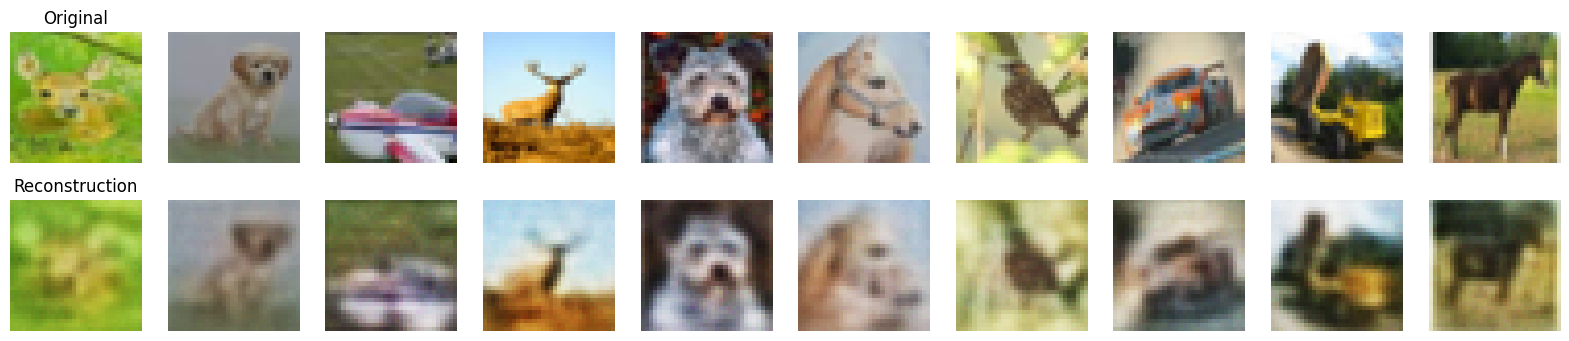

In [ ]:
decoded_val = AE_dense.predict(x_val)
display_images(x_val, decoded_val, n=10)

# **Evaluate Autoencoder #4 on Test Set**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031 - mae: 0.0391
Test loss, test mae: [0.003113078884780407, 0.03898366540670395]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


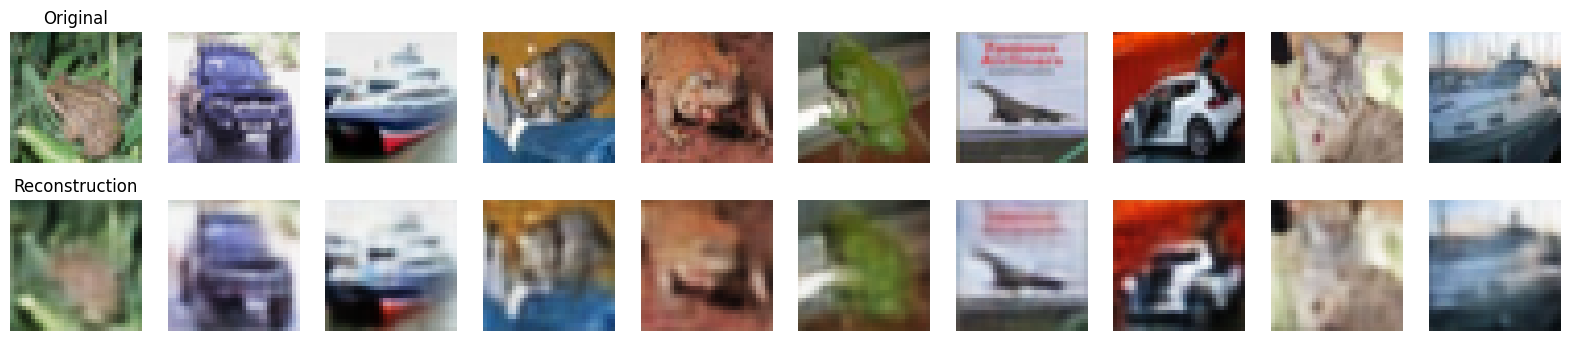

In [ ]:
test_metrics = AE4.evaluate(x_test, x_test, verbose=1)
print("Test loss, test mae:", test_metrics)

decoded_test = AE4.predict(x_test[:10])
display_images(x_test[:10], decoded_test, n=10)

# **Learning Curve of Autoencoder #4**

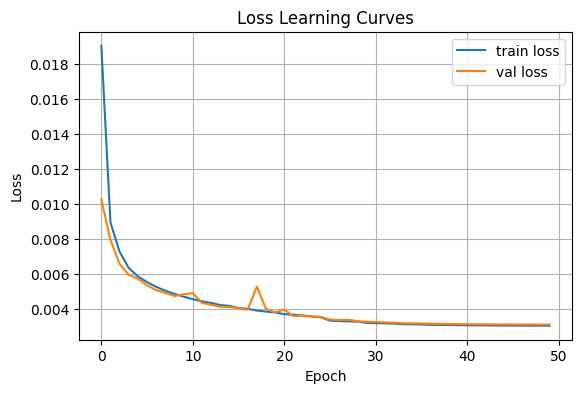

In [ ]:
plt.figure(figsize=(14,4))

# Loss
plt.subplot(1,2,1)
plt.plot(metrics4.history["loss"], label="train loss")
plt.plot(metrics4.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Learning Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# **PCA comparison with Dense Autoencoder**

PCA is basically an Autoencoder with Linear Activations. I wanted to compare it with an Autoencoder with non-linear activations. However, PCA doesn't necessarily return [0,1] values after decompression, so I have to clip the pixel values between [0,1] to make a fair comparison. Let's see the results with and without clipping to understand the difference. We will see it only loss-wise, not visually, because Matplotlib auto clips the pixel values internally.

In [ ]:
X_train_flat = x_train.reshape(len(x_train),-1)
X_val_flat   = x_val.reshape(len(x_val),-1)

latent_dim = 512

pca = PCA(n_components=latent_dim, random_state=42)
pca.fit(X_train_flat)

PCA(n_components=512, random_state=42)

In [ ]:
X_val_pca_enc = pca.transform(X_val_flat)
X_val_pca_dec  = pca.inverse_transform(X_val_pca_enc)          # NO CLIP
X_val_pca_clip = np.clip(X_val_pca_dec, 0.0, 1.0)              # WITH CLIP


In [ ]:
mse_no  = mean_squared_error(X_val_flat, X_val_pca_dec)
mae_no  = mean_absolute_error(X_val_flat, X_val_pca_dec)

mse_cl  = mean_squared_error(X_val_flat, X_val_pca_clip)
mae_cl  = mean_absolute_error(X_val_flat, X_val_pca_clip)

print(f"PCA no-clip  | MSE: {mse_no:.6f}  MAE: {mae_no:.6f}")
print(f"PCA clip     | MSE: {mse_cl:.6f}  MAE: {mae_cl:.6f}")

PCA no-clip  | MSE: 0.001033  MAE: 0.022599
PCA clip     | MSE: 0.001017  MAE: 0.022317


We see just a tiny difference on the errors, which means that only a few pixel values go out of [0,1] during reconstruction.

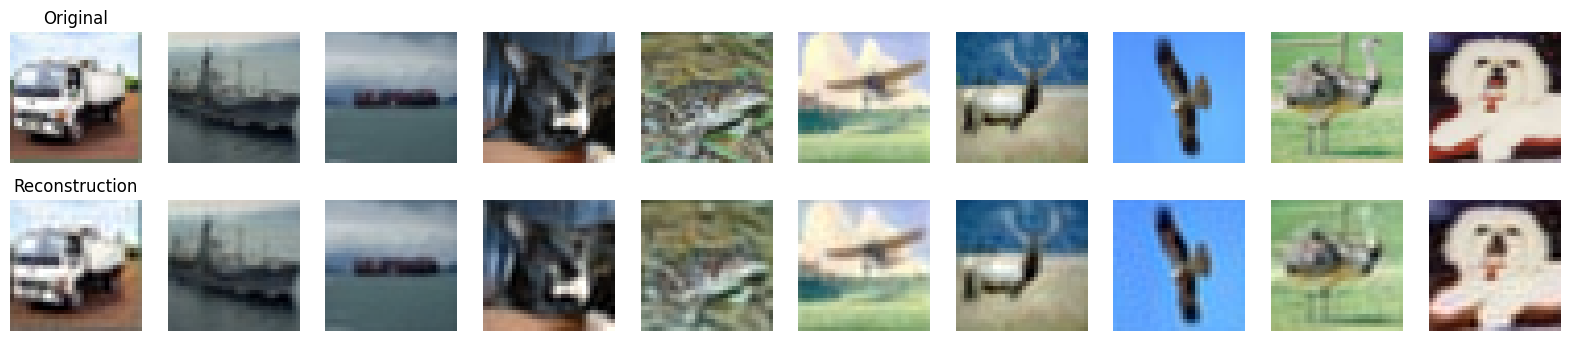

In [ ]:
x_val_pca = X_val_pca_clip.reshape(-1,32,32,3)
display_images(x_val, x_val_pca, n=10)

# **Encoder + Classification**

In [ ]:
encoder = Model(inputs=AE4.input, outputs=AE4.get_layer("latent").output, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

# **Encoder + CNN for classification**

In [ ]:
encoder.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# 2) CNN που δέχεται latent dimensions "εικονες"
cnn = Sequential([
    Input(shape=(4,4,128)),

    # BLOCK 1
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2,2), strides=2),

    # BLOCK 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),

    Dense(10, activation='softmax')
], name ="cnn")

In [ ]:
input_img = Input(shape=(32,32,3))
z = encoder(input_img)
out = cnn(z)

encoder_cnn = Model(input_img, out, name="encoder_cnn")

encoder_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

encoder_cnn.summary()

Model: "encoder_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 4, 4, 128)      │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn (Sequential)                │ (None, 10)             │       122,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,818 (843.04 KB)

 Trainable params: 121,674 (475.29 KB)

 Non-trainable params: 94,144 (367.75 KB)

In [ ]:
start = time.time()
history = encoder_cnn.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), shuffle=True, callbacks=[early_stopping, lr_scheduler])
train_time = time.time()-start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.3101 - loss: 1.8510 - val_accuracy: 0.2576 - val_loss: 2.2509 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4765 - loss: 1.4405 - val_accuracy: 0.4514 - val_loss: 1.5488 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5238 - loss: 1.3221 - val_accuracy: 0.5490 - val_loss: 1.2517 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5563 - loss: 1.2538 - val_accuracy: 0.5158 - val_loss: 1.3546 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5849 - loss: 1.1861 - val_accuracy: 0.5436 - val_loss: 1.2774 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6021 - loss: 1.1346
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6021 - l

# **Learning Curves**

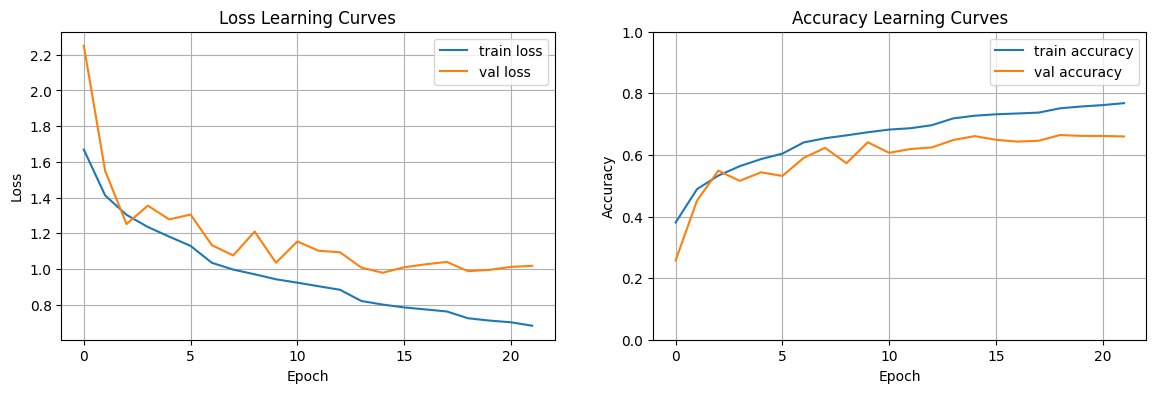

In [ ]:
plt.figure(figsize=(14,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Learning Curves")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curves")
plt.ylim(0,1)
plt.legend()
plt.grid(True)

plt.show()

# **Evaluate on Test Set**

In [ ]:
test_loss, test_acc = encoder_cnn.evaluate(x_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6530 - loss: 0.9937
Test accuracy: 0.6504999995231628


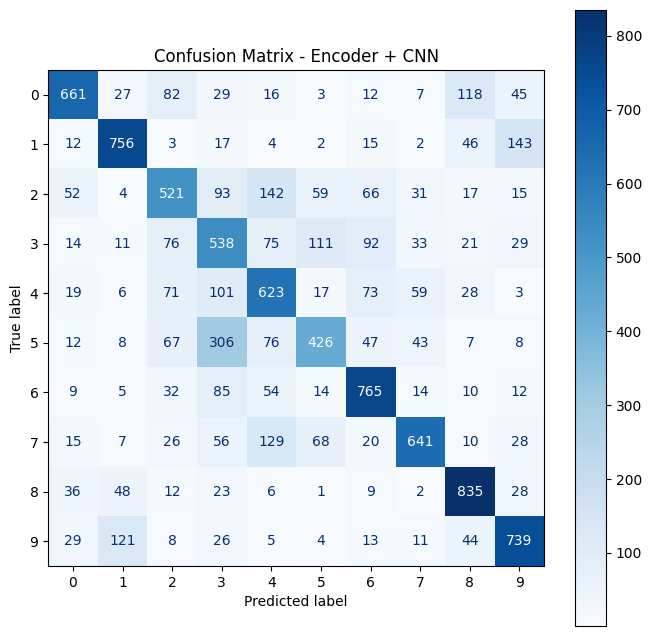

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      1000
           1       0.76      0.76      0.76      1000
           2       0.58      0.52      0.55      1000
           3       0.42      0.54      0.47      1000
           4       0.55      0.62      0.58      1000
           5       0.60      0.43      0.50      1000
           6       0.69      0.77      0.72      1000
           7       0.76      0.64      0.70      1000
           8       0.74      0.83      0.78      1000
           9       0.70      0.74      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



In [ ]:
y_pred = np.argmax(encoder_cnn.predict(x_test, verbose=0), axis=1)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=True)
plt.title("Confusion Matrix - Encoder + CNN")
plt.show()

print(classification_report(y_test, y_pred))

# **Trainable Encoder + CNN**

In [ ]:
cnn2 = Sequential([
    Input(shape=(4,4,128)),

    # BLOCK 1
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2,2), strides=2),

    # BLOCK 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),

    Dense(10, activation='softmax')
], name ="cnn")

In [ ]:
encoder.trainable = True
input_img = Input(shape=(32,32,3))
z = encoder(input_img)
out = cnn2(z)

encoder_cnn2 = Model(input_img, out, name="encoder_cnn2")

encoder_cnn2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
history1 = encoder_cnn2.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), shuffle=True, callbacks=[early_stopping, lr_scheduler])
train_time = time.time()-start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.4447 - loss: 1.5226 - val_accuracy: 0.6296 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6886 - loss: 0.9177 - val_accuracy: 0.6978 - val_loss: 0.8550 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7369 - loss: 0.7829 - val_accuracy: 0.6962 - val_loss: 0.9103 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7752 - loss: 0.6805 - val_accuracy: 0.7074 - val_loss: 0.8601 - learning_rate: 0.0010
Epoch 5/50
1397/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7951 - loss: 0.6222
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7951 - loss: 0.6223 - val_accuracy: 0.6794 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8419 - l

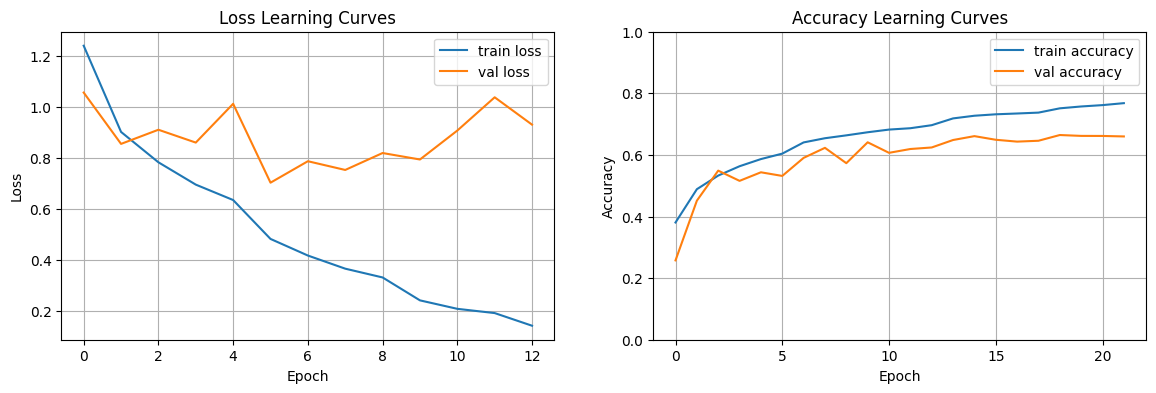

In [ ]:
plt.figure(figsize=(14,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history1.history["loss"], label="train loss")
plt.plot(history1.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Learning Curves")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curves")
plt.ylim(0,1)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
test_loss, test_acc = encoder_cnn2.evaluate(x_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7679 - loss: 0.7186
Test accuracy: 0.7663000226020813


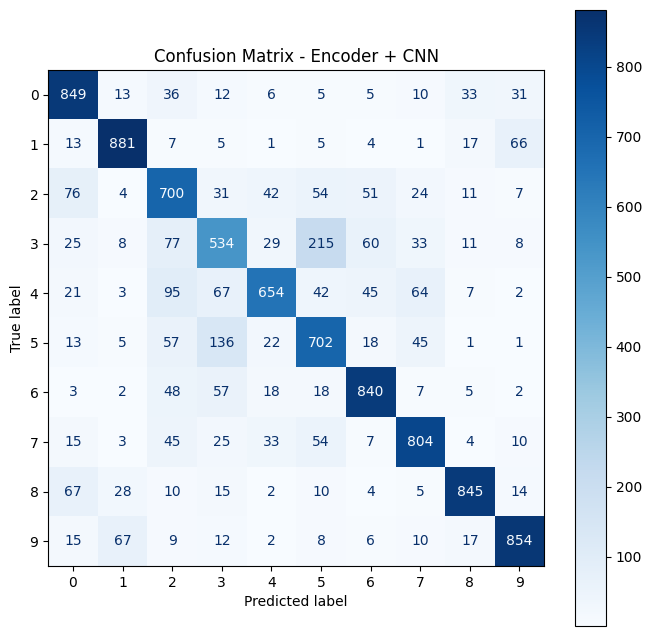

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.87      0.88      0.87      1000
           2       0.65      0.70      0.67      1000
           3       0.60      0.53      0.56      1000
           4       0.81      0.65      0.72      1000
           5       0.63      0.70      0.66      1000
           6       0.81      0.84      0.82      1000
           7       0.80      0.80      0.80      1000
           8       0.89      0.84      0.87      1000
           9       0.86      0.85      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [ ]:
y_pred = np.argmax(encoder_cnn2.predict(x_test, verbose=0), axis=1)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=True)
plt.title("Confusion Matrix - Encoder + CNN")
plt.show()

print(classification_report(y_test, y_pred))

# **Encoder + SVM**

In [ ]:
latent_dim = 512

# Encoder
inp = Input(shape=(32, 32, 3), name="img")

x = Conv2D(32, (3,3), activation="relu", padding="same")(inp)
x = MaxPooling2D((2,2), padding="same")(x)          # 16x16x32

x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), padding="same")(x)          # 8x8x64

x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), padding="same")(x)          # 4x4x128

x = Flatten()(x)
z = Dense(latent_dim, name="z")(x)

encoder = Model(inp, z, name="encoder_vec")


# Decoder
d = Dense(4*4*128, activation="relu")(z)
d = Reshape((4,4,128))(d)

d = Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(d)  # 8x8x128
d = Conv2DTranspose(64,  (3,3), strides=2, padding="same", activation="relu")(d)  # 16x16x64
d = Conv2DTranspose(32,  (3,3), strides=2, padding="same", activation="relu")(d)  # 32x32x32

out = Conv2D(3, (3,3), padding="same", activation="sigmoid", name ="output")(d)

ae = Model(inp, out, name="ae_vec")
ae.summary()
encoder.summary()



Model: "ae_vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,667 (9.28 MB)

 Trainable params: 2,433,667 (9.28 MB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder_vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 512)            │     1,049,088 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,336 (4.36 MB)

 Trainable params: 1,142,336 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
t0 = time.perf_counter()
historyy = ae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_val, x_val), callbacks=[early_stopping, lr_scheduler], shuffle=True)
train_time = time.perf_counter()-t0
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 0.0359 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0118 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0096 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0084 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0074 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0066 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0061 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0058 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0055 - val_loss: 0.0054 - learning_rate: 0.0010


In [ ]:
x_sub, _, y_sub, _ = train_test_split(x_train, y_train,test_size=0.8, random_state=42, stratify=y_train)

In [ ]:
Z_train = encoder.predict(x_sub, batch_size=256)
Z_val   = encoder.predict(x_val, batch_size=256)
Z_test = encoder.predict(x_test, batch_size=256)
print(Z_train.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(9000, 512)


In [ ]:
Z_train_flat = Z_train.reshape(len(Z_train), -1)
Z_val_flat   = Z_val.reshape(len(Z_val), -1)
Z_test_flat = Z_test.reshape(len(Z_test), -1)
print(Z_train_flat.shape)

(9000, 512)


In [ ]:
scaler = StandardScaler()
Z_train_sc = scaler.fit_transform(Z_train_flat)
Z_val_sc   = scaler.transform(Z_val_flat)
Z_test_sc = scaler.transform(Z_test_flat)
y_sub_reshaped = y_sub.reshape(-1)

In [ ]:
svm1 = LinearSVC(C=1.0, max_iter=3000)
t0 = time.perf_counter()
svm1.fit(Z_train_sc, y_sub_reshaped)
train_time = time.perf_counter()-t0
print(f"Linear SVM training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Linear SVM training time: 47.21 sec (0.79 min)


In [ ]:
t0 = time.perf_counter()
y_tr_pred = svm1.predict(Z_train_sc)
y_val_pred = svm1.predict(Z_val_sc)
y_test_pred = svm1.predict(Z_test_sc)
train_acc = accuracy_score(y_sub, y_tr_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)
pred_time = time.perf_counter()-t0
print(f"Prediction time: {pred_time:.2f} sec")
print(f"Encoder + SVM training accuracy: {train_acc:.4f}")
print(f"Encoder + SVM validation accuracy: {val_acc:.4f}")
print(f"Encoder + SVM test accuracy: {test_acc:.4f}")


Prediction time: 0.06 sec
Encoder + SVM training accuracy: 0.6691
Encoder + SVM validation accuracy: 0.5138
Encoder + SVM test accuracy: 0.5121


# **Denoising Autoencoder on STL-10 (for higher resolution images: 96x96)**

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load("stl10", split=["train", "test"], as_supervised=True, with_info=True)

def tfds_to_numpy(ds):
    images = []
    for x, y in tfds.as_numpy(ds):
        images.append(x)
    return np.array(images)

x_train_full = tfds_to_numpy(ds_train)
x_test3 = tfds_to_numpy(ds_test)

print(x_train_full.shape)
print(x_test3.shape)


(5000, 96, 96, 3)
(8000, 96, 96, 3)


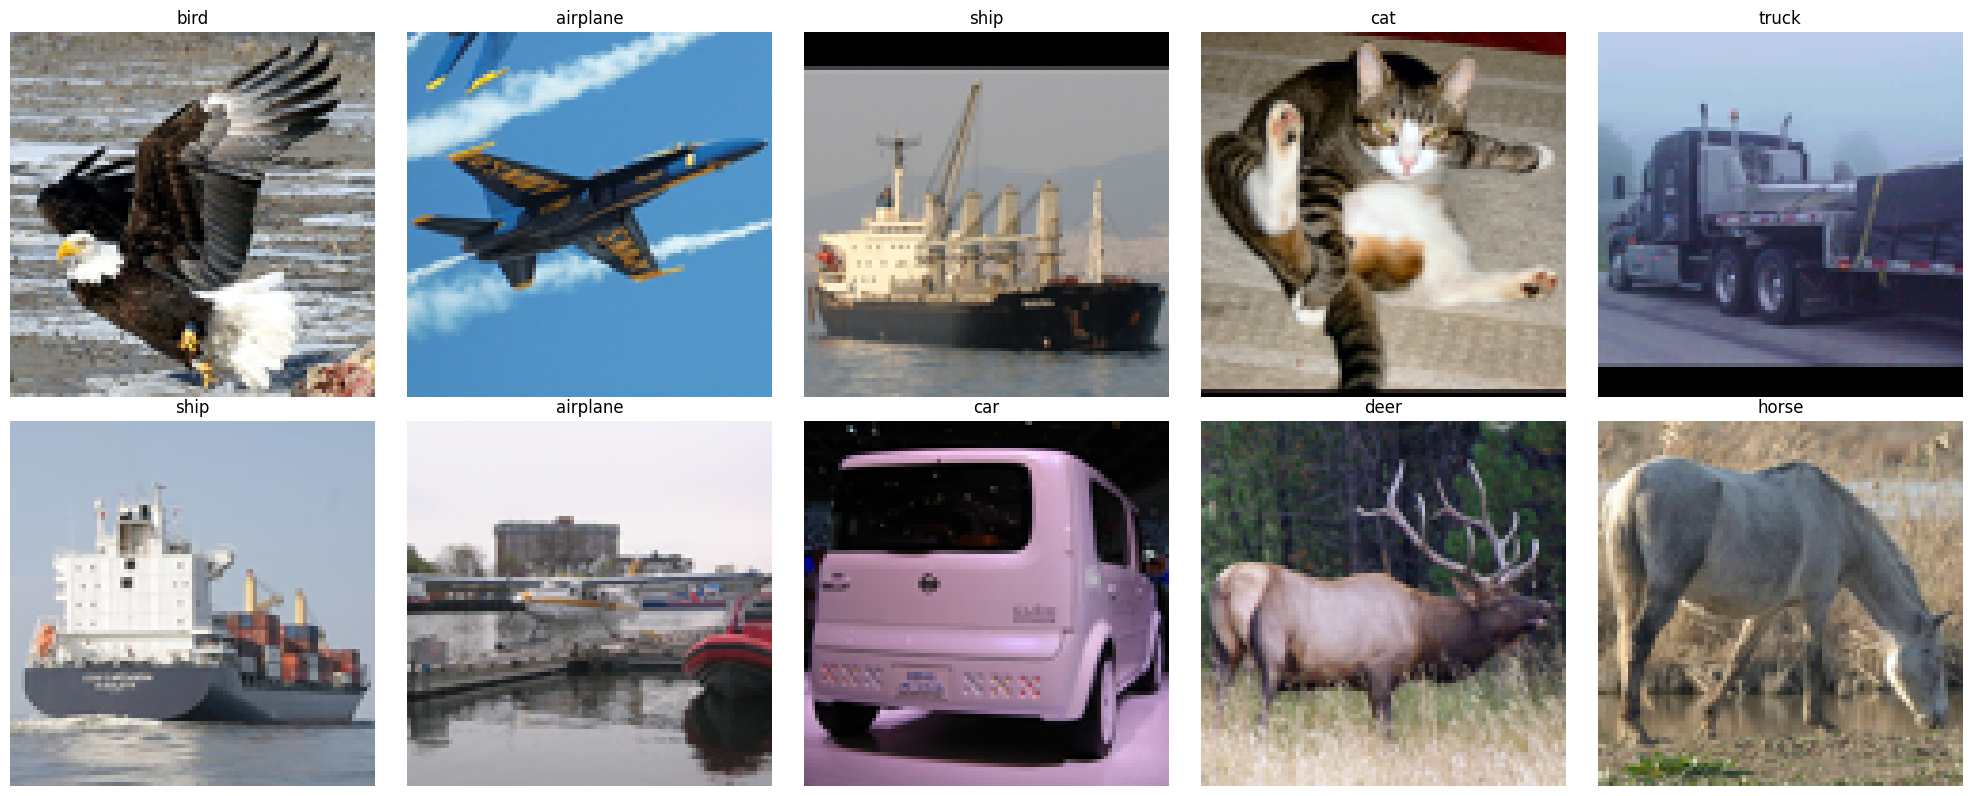

In [3]:
samples = []
labels = []

for img, lbl in tfds.as_numpy(ds_train.take(16)):
    samples.append(img)
    labels.append(lbl)

samples = np.array(samples)
labels = np.array(labels)

class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

plt.figure(figsize=(20, 8))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i])
    plt.title(class_names[labels[i]], fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
x_train_full = x_train_full.astype("float32") / 255.0
x_test3 = x_test3.astype("float32") / 255.0

In [5]:
x_train3, x_val3 = train_test_split(x_train_full, test_size=0.2, random_state=42, shuffle=True)

print("Train images shape:", x_train3.shape, "\nValidation images shape:", x_val3.shape, "\nTest images shape:", x_test3.shape)

Train images shape: (4000, 96, 96, 3) 
Validation images shape: (1000, 96, 96, 3) 
Test images shape: (8000, 96, 96, 3)


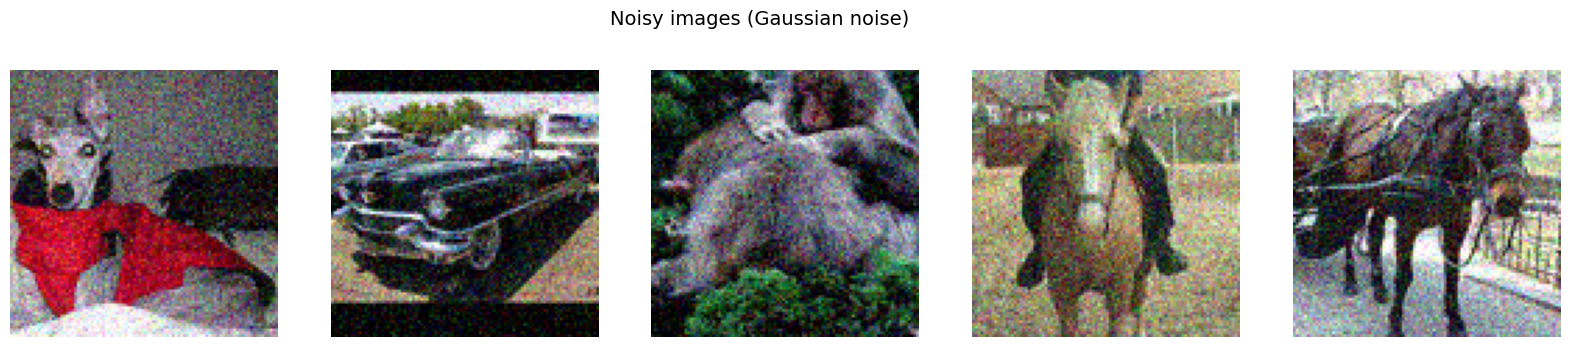

In [6]:
noise_std = 0.1
rng = np.random.default_rng(42)

x_train_noisy = np.clip(x_train3 + np.random.normal(0, noise_std, x_train3.shape), 0, 1)
x_val_noisy = np.clip(x_val3 + np.random.normal(0, noise_std, x_val3.shape), 0, 1)
x_test_noisy = np.clip(x_test3 + np.random.normal(0, noise_std, x_test3.shape), 0, 1)

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_noisy[i])
    plt.axis("off")

plt.suptitle("Noisy images (Gaussian noise)", fontsize=14)
plt.show()

In [7]:
input_img = Input(shape=(96, 96, 3))

# Encoder
x = Conv2D(32, 3, activation="relu", padding="same")(input_img)    # 96x96x32
x = MaxPooling2D(2, padding="same")(x)      # 48x48x32

x = Conv2D(64, 3, activation="relu", padding="same")(x)    # 48x48x64
x = MaxPooling2D(2, padding="same")(x)      # 24x24x54

x = Conv2D(128, 3, activation="relu", padding="same")(x)    # 24x24x64
latent = MaxPooling2D(2, padding="same")(x) # 12x12x64

# Decoder
x = Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(latent)  # 24x24x64

x = Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)       # 48x48x64

x = Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)        # 96x96x32

output_img = Conv2D(3, 1, activation="sigmoid", padding="same")(x)    # 96x96x3

dAE = Model(input_img, output_img, name="denoising_autoencoder")
dAE.summary()

Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 24, 24, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 48, 48, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 96, 96, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 3)      │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,187 (1.27 MB)

 Trainable params: 333,187 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
dAE.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

In [10]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)]

start = time.time()
history2 = dAE.fit(x_train_noisy, x_train3, validation_data=(x_val_noisy, x_val3), epochs=50, batch_size=64, shuffle=True, callbacks=callbacks, verbose=1)
train_time = time.time()-start
print(f"Training time: {train_time:.2f} sec ({train_time/60:.2f} min)")

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - loss: 0.0572 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0192 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0155 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0140 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0109 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0097 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0092 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0089 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0092 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 10/50
63/63

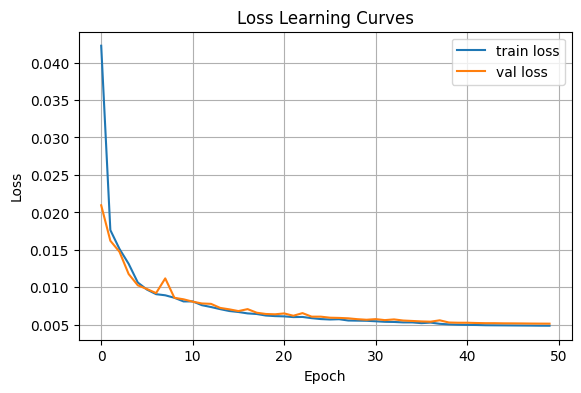

In [11]:
plt.figure(figsize=(14,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history2.history["loss"], label="train loss")
plt.plot(history2.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Learning Curves")
plt.legend()
plt.grid(True)

plt.show()

In [12]:
test_mse = dAE.evaluate(x_test_noisy, x_test3, verbose=0)
print("Test MSE (noisy→clean):", test_mse)

Test MSE (noisy→clean): 0.00500957015901804


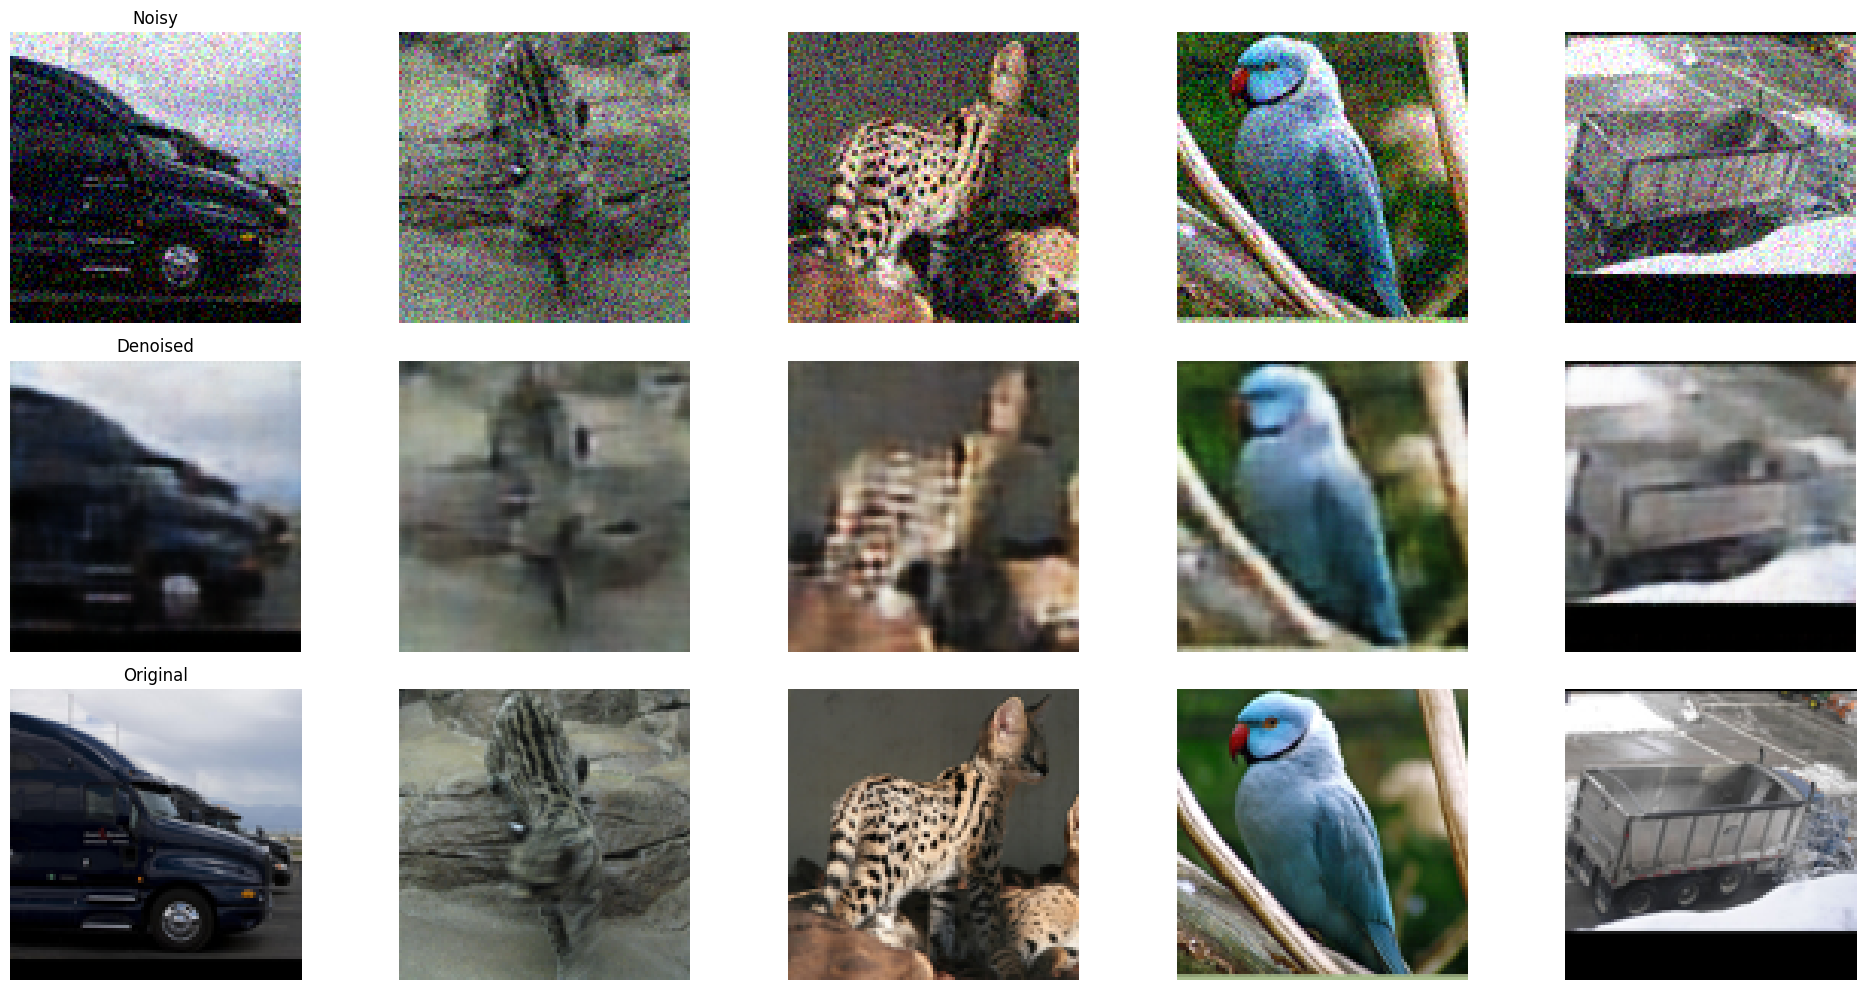

In [16]:
n=5
x_clean = x_test3[:n]
x_test_denoised = dAE.predict(x_test_noisy, verbose=0)

plt.figure(figsize=(20, 10))
for i in range(n):
    plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i]); plt.axis("off")
    if i == 0: plt.title("Noisy")

    plt.subplot(3, n, n+i+1)
    plt.imshow(x_test_denoised[i]); plt.axis("off")
    if i == 0: plt.title("Denoised")

    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(x_clean[i]); plt.axis("off")
    if i == 0: plt.title("Original")

plt.tight_layout()
plt.show()